# Generalized Epidemic Model

_This is meant for educational purposes only. No policy decisions should be taken based on this model. All values are purely representative._

Through this model, we will try to understand the trajectory of an epidemic in time. Along the way we will also clarify some misconceptions about common observables that tend to be discussed in the news cycle.

An observable is a quantity we can easily measure during an epidemic by means of extensive testing. 

__For a non-mathematical overview feel free to skip straight to the figures and their descriptions!__

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import numerical_integration as ni
import seaborn as sns; sns.set_style('whitegrid')

## Parameters

Let's start with a population of $N$ people.

We define $R_{0}$ (Basic Reproduction No.) which is the average number of people a single infected individual passes on the pathogen to when the epidemic has just begun. This is the parameter to keep in mind!

Next, we define the cumulative removal rate $\nu$, which is the sum of the recovery and death rate of the disease. Finally, we define $\gamma$ which is the rate of loss of immunity to the disease once removed. <br>
_In this model, __removal__ means that an individal has either succumbed to or recovered from the disease._

$\beta = R_{0}N/\nu$ is a derived parameter that is proportional to probablity of contact between susceptible and infected individuals in the population.

__Parameters:__ $R_{0}$, $\nu$, $\gamma$ 

The total time period is $T$ in days and $dt$ is the interval in which the count is updated.

To avoid confusion note that $R_0$ is different from  $R_t$ (Effective Reproduction No.) which is the average number of people a single infected individual passes on the disease to at any given instant during the epidemic. $R_t = \dfrac{SR_0}{N}$.

In [2]:
R0 = 2 #basic reproduction number

In [3]:
#defining other parameters
T = 100 #T is the total number of days
dt = 1 #dt is the time interval in which the count is updated
N = 1e3 #total number of individuals
c = 0.2 #removal rate
d = 0.0001 #if SIR then d = 0, for SIRS d>0 #rate of loss of immunity post removal

#derived quantities
b = R0*c/N

## SIRS Model
The SIRS Model is governed by the following equations:

$\dot{S} = -\beta I S + \gamma R$

$\dot{I} = \beta I S - \nu I$

$\dot{R} = \nu I - \gamma R$

where $S$ is the number of susceptible people, $I$ is the number of infected people and $R$ is the number of removed people in the population.<br>
A trivial conservation law $N = S + I + R$ holds.

__SIR Model__ is the special case when $\gamma = 0$. 

_Note:_ For __COVID-19__ initial results indicate $\gamma$ to be close to 0. We make this assumption in our model.

In [4]:
#defining differential equations
def F(x,y):
    f = -b*y*x + d*(N-(x+y))
    return f

def G(x,y):
    g = b*y*x - c*y
    return g

We need to define initial number of infected individuals. In this case we choose 1% of the population to be infected.

In [5]:
#initial state
I0 = N*1/100 #initial infected individuals
S0 = N - I0 #initial susceptible individuals

In [6]:
S,I,t = ni.eulerFG(F,G,S0,I0,T,dt)
R = N-(S+I)
df = pd.DataFrame({'S':S, 'I':I, 'R':R, 't':t})

### The Curve to Flatten

The trajectory of the three variables ($S$,$I$ and $R$) are plotted as a percentage of the total population. __All key observables in this notebook are shown in dark orange__.

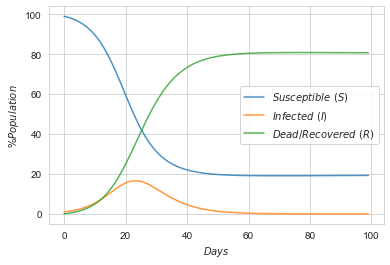

In [7]:
plt.plot(df['t'],df['S']/N*1e2,alpha = 0.8)
plt.plot(df['t'],df['I']/N*1e2,alpha = 0.8)
plt.plot(df['t'],df['R']/N*1e2,alpha = 0.8)
plt.legend(['$Susceptible\ (S)$','$Infected\ (I)$','$Dead/Recovered\ (R)$'])
plt.xlabel('$Days$'); plt.ylabel('$\%Population$')
plt.show();

__1\.__ The first obervable - __Number of Infected Persons__, is a useful way to see the maximum load on the healthcare system. The flatter the curve, the lower the maximum load during an epidemic. If the curve is flattened and elongated, we should expect minimum deaths due to the disease. In the news cycle, this observable is often called **_Number of Active Cases_**.
    
If this observable peaks in an __uncontrolled__ system, the population has acquired herd immunity. This is because after a certain number of people have fallen sick and recovered, there are fewer susceptible people left to infect. 
    
Note that __the area under this curve is NOT equal to the cumulative number of cases__ since the epidemic began. This is because once someone falls sick, they take a certain number of days to recover and hence, if we add up the number of infected people everyday, we will end up double counting many patients.

### The Curve to Track

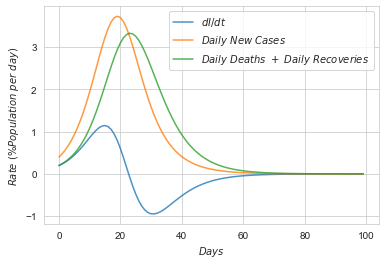

In [8]:
plt.plot(df['t'],(b*df['I']*df['S']-c*df['I'])/N*1e2,alpha = 0.8);
plt.plot(df['t'],(b*df['I']*df['S'])/N*1e2,alpha = 0.8);
plt.plot(df['t'],c*df['I']/N*1e2,alpha = 0.8);
plt.legend(['$dI/dt$', '$Daily\ New\ Cases$', '$Daily\ Deaths\ + \ Daily\ Recoveries$']);
plt.xlabel('$Days$'); plt.ylabel('$Rate\ (\% Population\ per\ day)$');

The rates of infection and removal add up to give us the net rate of change in $I$. 

__2\.__ __Daily New Cases__ tell us if any interventions have been useful. This is the observable to watch when it comes to policy-making. Effective policy should aim to flatten this curve.

The peak in number of infected cases is achieved when $dI/dt = 0$. Notably, this is __NOT__ the same as saying that the number of daily new cases has gone to 0. Therefore, once herd immunity is acquired, cases will _continue_ to grow. This is known as 'overshoot'. This will be clearer when we look at the next observable.
    
The endgame is pushing this curve to 0.

### The Curve to Climb

In [9]:
df['cumulative'] = ni.euler_rate(b*df['I']*df['S'], df['t'], df['I'][0])

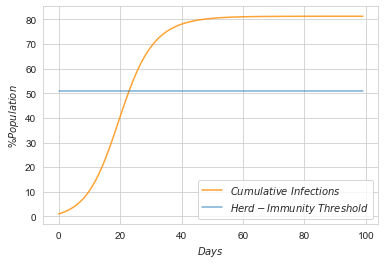

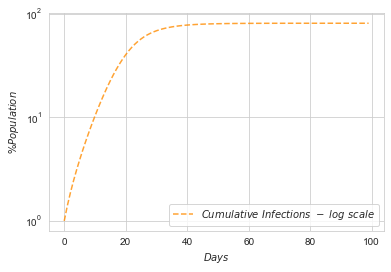

In [10]:
plt.plot(df['t'],df['cumulative']/N*1e2, 'darkorange', alpha = 0.8)

plt.plot(df['t'],(np.array(df['cumulative'].loc[df['I']==np.max(df['I'])])*np.ones(np.size(df['t'])))*1e2/N, alpha = 0.6)
plt.xlabel('$Days$'); plt.ylabel('$\%Population$')
plt.legend(['$Cumulative\ Infections$','$Herd-Immunity\ Threshold$'])
plt.show();

plt.plot(df['t'],df['cumulative']/N*1e2, '--', color = 'darkorange', alpha = 0.8)
plt.xlabel('$Days$'); plt.ylabel('$\%Population$')
plt.legend(['$Cumulative\ Infections\ -\ log\ scale$'])
plt.yscale('log');

__3\.__ The third main observable: __cumulative infections over time__. This is found by integrating over daily new cases, i.e. by calculating the area under the _daily-new-cases_ curve. Plotting on a log scale tells us which phase of growth the system is in.
    
Note here that the threshold number of cases required for acquiring herd immunity is lower than the total cumulative number of cases as $t \rightarrow \infty$. This is exactly what we mean by "overshoot"!

## Phase Space Analysis

Skip over to the section on $R_{0}$ if a _'phase-space'_ sounds unfamiliar.

In [11]:
ax_max = N
sp = N/20

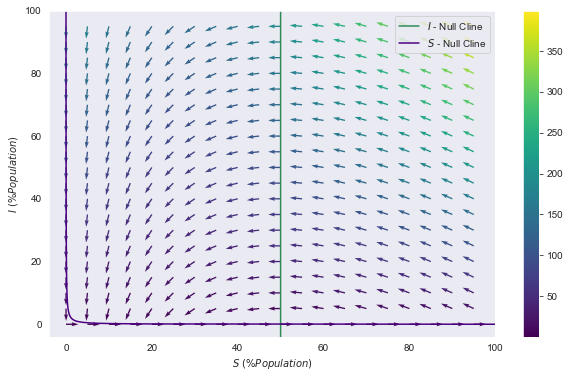

In [12]:
sns.set_style('dark')

plt.figure(figsize=(10,6))
plt.xlabel('$S\ (\% Population)$'); plt.ylabel('$I\ (\% Population)$')

y_1 = np.arange(-N/10,ax_max); x_1 = (c/b)*np.ones(np.size(y_1))
y_2 = np.arange(-N/10,ax_max); x_2 = d*(N-y_2)/(b*y_2 + d)
y_2 = y_2[x_2>0]; x_2 = x_2[x_2>0]

plt.plot(x_1/N*1e2,y_1/N*1e2,'-', color = 'seagreen')
plt.plot(x_2/N*1e2,y_2/N*1e2,'-', color = 'indigo')

U,V,X,Y,C = ni.vectorize(F,G,ax_max,sp)
Q = plt.quiver(X/N*1e2,Y/N*1e2,U,V,C,cmap = 'viridis')
plt.ylim(-4, ax_max/N*1e2); plt.xlim(-4,ax_max/N*1e2)
plt.legend(['$I$ - Null Cline', '$S$ - Null Cline'])
plt.colorbar(); sns.set_style('whitegrid')

For an __SIR Model__ as shown above, the system has only one stable state at $I = 0$. This is good news! If reinfection is negligible, the disease WILL disappear. 

But this is not the case if reinfection is possible. In __SIRS models__ $(\gamma >> 0)$ a second stable point given by the intersection of the two null clines appears. This implies that the disease could establish itself in the population, i.e. at any given point in time some fraction of people will be sick.

### Herd Immunity in SIR Models:
To the left of the I-Null Cline, $I$ is always decreasing. This gives us a useful way to picture the idea of herd immunity. If we can bring the value of $S$ down to where the I-Null Cline intersects with the X-axis then $I$, no matter how high it is at that instant, will decline to 0.

Now we have a value of $S$ to aim for. Let's call this $S^*$. This means $I^* = N-S^*$ number of people have to fall sick in total for the population to acquire "herd immunity". 

A quick derivation shows that the I-Null Cline intersects the X-axis when $S = \nu/\beta$. Therefore $S^* = \nu/\beta$ and $I^* = N - \nu/\beta$.

As a fraction of the population $\dfrac{I^*}{N} = 1 - \dfrac{1}{R_0}$.
This value is often called the "Herd Immunity Threshold" — the total fraction of the population needed to fall sick for acquiring herd immunity.

As shown before, this threshold can be measured by finding out the number of cumulative infections when the $I$ curve peaks.

## $R_0$ — The Control Knob

It is likely that you have come across some discussion about $R_0$ during this pandemic. This is because unlike other parameters $\nu$ and $\gamma$, it can be controlled easily by us as a society. So what can we do by lowering $R_0$ i.e. by "flattening the curve"?

1. Reduce __Maximum Healthcare Load__ - i.e. the maximum number of patients who will be ill on any given day during the pandemic.
2. Reduce the __Herd-Immunity Threshold__ - i.e. the total number of people who have to fall ill since the pandemic began to achieve herd immunity.
3. Reduce the __Burden of the Disease__ - i.e the total number of people who will fall sick during the pandemic.

As a simple demonstration, we will plot the three variables given above against $R_0$.

In [13]:
r0 = np.arange(1.1,5,0.1)

In [14]:
L = np.zeros(np.size(r0))
Hth = np.zeros(np.size(r0))
Tinf = np.zeros(np.size(r0))
for i, R0 in enumerate(r0):
    b = R0*c/N
    S,I,t = ni.eulerFG(F,G,S0,I0,10*T,dt)
    R = N-(S+I)
    cum = ni.euler_rate(b*I*S, t, I[0])
    L[i] = np.max(I)/N*1e2
    Hth[i] = np.array(cum[I==np.max(I)])/N*1e2
    Tinf[i] = np.max(R)/N*1e2

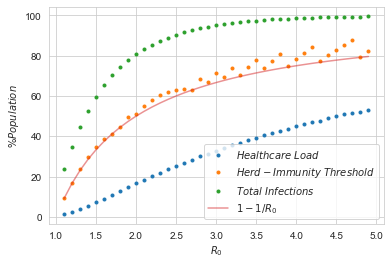

In [15]:
plt.plot(r0,L,'.');
plt.plot(r0,Hth,'.');
plt.plot(r0,Tinf,'.');
plt.plot(r0,(1-(1/r0))*100,alpha = 0.5);
plt.legend(['$Healthcare\ Load$', '$Herd-Immunity\ Threshold$', '$Total\ Infections$','$1-1/R_0$'])
plt.xlabel('$R_0$'); plt.ylabel('$\%Population$');
plt.savefig('varying_R0',dpi=300);

If you update the count at shorter and shorter intervals (say 10 times a day), the measured Herd-Immunity Threshold gets closer and closer to the theoretical value $1-1/R_0$.

__"Flattening the curve" implies that we reduce the total number of people who end up getting the disease, we reduce the load on the healthcare system AND we reduce the threshold required for us to attain herd immunity.__